In [1]:
# Python version
from platform import python_version
print('Python version used in this Jupyter Notebook:', python_version())

Python version used in this Jupyter Notebook: 3.7.6


# Netflix Movies Recommendation System

## Problem description

<p>
Netflix's goal is to connect people to the movies they love. To help customers find these movies, they've developed a world-class movie recommendation system: CinematchSM. Your job is to predict whether someone will like a movie based on how much they liked other movies or not. Netflix uses these predictions to make personal movie recommendations based on each customer's unique tastes. And while <b> Cinematch </b> is doing very well, it can always be improved.
</p>
<p> There are a number of interesting alternative approaches to how Cinematch works that netflix has yet to try. Some are described in the literature, others are not. We're curious to know if any of them can beat Cinematch by making better predictions. Because frankly, if there's a much better approach, it could make a big difference to our customers and our business. </p>

Objectives:

1. Predict the rating a user would give a movie they haven't rated yet
2. Minimize the difference between predicted and actual assessment (RMSE and MAPE).

Restrictions:

1. Some form of interpretability.

## Data Source

<p>
Netflix provided a lot of anonymized rating data and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training dataset. Accuracy is a measure of how closely predicted movie ratings match subsequent actual ratings.
</p>

<ul>
<li> <a href="https://www.netflixprize.com/rules.html">Netflix Prize</a></li>
<li> <a href="https://www.kaggle.com/netflix-inc/netflix-prize-data">Dataset</a></li>

## Instalando e Carregando os Pacotes

In [ ]:
# Installing watermark package
!pip install -q -U watermark

In [4]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# Formatting the graphics
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

In [5]:
# Packages versions in this Jupyter Notebook
%reload_ext watermark
%watermark -a "Jupyter notebook of DRGM" --iversions

Author: Jupyter notebook of DRGM

pandas    : 1.2.2
seaborn   : 0.11.1
sklearn   : 0.24.2
numpy     : 1.21.6
scipy     : 1.4.1
matplotlib: 3.4.2



## Loading the data

To load the data, we will perform the following operations:

- 1- Read the lines of all available files.

- 2- Combine all lines from all files into a single file.

- 3- Load the generated file into a pandas dataframe.

In [4]:
# Beginning the execution
start = datetime.now()

In [23]:
# We will create a final file named dados.csv

# If the file does not exist, we create the file in write mode (w)
if not os.path.isfile('dados/dados.csv'):
    
    # Create and open the file for writing
    dataset = open('dados/dados.csv', mode = 'w')
    
    # List for file lines
    linhas = list()
    
    # File names and paths
    arquivos = ['dados/combined_data_1.txt',
                'dados/combined_data_2.txt',
                'dados/combined_data_3.txt',
                'dados/combined_data_4.txt']
    
    # Loop through each file in the file list
    for arquivo in arquivos:
        
        # Print
        print('Lendo o arquivo {}...'.format(arquivo))
        
        # With the file open, we extract the lines
        with open(arquivo) as f:
            
            # Loop through each line in the file
            for linha in f:
                
                # We delete the contents of the list
                del linhas[:] 
                
                # Divide the lines of the file by the end-of-line character
                linha = linha.strip()
                
                # If we find "colon" at the end of the line, we do replace removing the character,
                # because we just want the movie ID
                if linha.endswith(':'):
                    movie_id = linha.replace(':','')
                    
                # If not, we create a list comprehension to separate the columns by comma
                else:
                    
                    # Separates the columns
                    linhas = [x for x in linha.split(',')]
                    
                    # Use movie ID at zero index position
                    linhas.insert(0, movie_id)
                    
                    # Save the result in a new file
                    dataset.write(','.join(linhas))
                    dataset.write('\n')
                    
        print('Concluido!\n')
        
    dataset.close()            

In [6]:
# Print the total time
print('Tempo Total para Carregar os Arquivos: ', datetime.now() - start)

Tempo Total para Carregar os Arquivos:  0:00:12.610396


In [26]:
print('Criando o dataframe Pandas a partir do arquivo dados.csv...')
df_netflix = pd.read_csv('dados/dados.csv', sep = ',', names = ['movie', 'user', 'rating', 'date'])
df_netflix.date = pd.to_datetime(df_netflix.date)
print('Concluido!\n')

Criando o dataframe Pandas a partir do arquivo dados.csv...
Concluido!



In [27]:
# Sorting the dataframe by date
print('Ordenando o dataframe por data..')
df_netflix.sort_values(by = 'date', inplace = True)
print('Concluido.')

Ordenando o dataframe por data..
Concluido.


In [38]:
# Shape
df_netflix.shape

(100480507, 4)

In [39]:
# Viewing the data
df_netflix.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


Working with 100 Million Records is not easy and it can consume a lot of computational resources. Some tips:

- 1- Close all files and software on your computer. Leave only what is really necessary.
- 2- Consider using a cloud environment or even a cluster of computers if possible.
- 3- Reduce the size of each file. Here are some suggestions for "File Splitter" software:

http://www.fastfilejoiner.com/

https://www.gdgsoft.com/gsplit/download

http://www.kcsoftwares.com/?kfk

## Exploratory Analysis

In [40]:
# Data summary
print('Resumo dos dados')
print('-' * 50)
print('Numero Total de Filmes:', len(np.unique(df_netflix.movie)))
print('Numero Total de Usuarios:', len(np.unique(df_netflix.user)))
print('Numero Total de Avaliacoes:', df_netflix.shape[0])

Resumo dos dados
--------------------------------------------------
Numero Total de Filmes: 17770
Numero Total de Usuarios: 480189
Numero Total de Avaliacoes: 100480507


In [28]:
# Let's save these two values to use later
total_users = len(np.unique(df_netflix.user))
total_movies = len(np.unique(df_netflix.movie))

In [12]:
# Checking the average of the evaluations
df_netflix.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [13]:
# Checking if we have missing values
sum(df_netflix.isnull().any())

0

In [14]:
# Checking if we have duplicate values (in this case we don't consider the date)
sum(df_netflix.duplicated(['movie', 'user', 'rating']))

0

Let's split the data into training and testing before proceeding with exploratory analysis, as some analyzes only make sense for training data. We will use the 80/20 ratio for training/testing.

In [15]:
# We will create a dataset on disk with the training data
# That way we don't need to run the entire loading process again each time we run this notebook.
if not os.path.isfile('dados/dados_treino.csv'):
    df_netflix.iloc[:int(df_netflix.shape[0] * 0.80)].to_csv('dados/dados_treino.csv', index = False)

In [19]:
# We will create a dataset on disk with the testing data
# That way we don't need to run the entire loading process again each time we run this notebook.
if not os.path.isfile('dados/dados_teste.csv'):
    df_netflix.iloc[int(df_netflix.shape[0] * 0.80):].to_csv('dados/dados_teste.csv', index = False)

In [29]:
# We deleted the original dataframe to free up memory
del df_netflix

When you run this Jupyter Notebook again, you can start from this cell below (after loading the packages).

If you have an error in Jupyter Notebook, refresh the tab with http://localhost:8888/tree.

In [2]:
# Now we load the files into pandas dataframe
df_netflix_treino = pd.read_csv('dados/dados_treino.csv', parse_dates = ['date'])
df_netflix_teste = pd.read_csv('dados/dados_teste.csv')

In [5]:
# Training data summary
print('Resumos dos dados de treino')
print('-' * 50)
print('Numero total de filmes:', len(np.unique(df_netflix_treino.movie)))
print('Numero total de usuarios:', len(np.unique(df_netflix_treino.user)))
print('Numero total de avaliacoes:', df_netflix_treino.shape[0])

Resumos dos dados de treino
--------------------------------------------------
Numero total de filmes: 17424
Numero total de usuarios: 405041
Numero total de avaliacoes: 80384405


In [6]:
# Testing data summary
print('Resumos dos dados de teste')
print('-' * 50)
print('Numero total de filmes:', len(np.unique(df_netflix_teste.movie)))
print('Numero total de usuarios:', len(np.unique(df_netflix_teste.user)))
print('Numero total de avaliacoes:', df_netflix_teste.shape[0])

Resumos dos dados de teste
--------------------------------------------------
Numero total de filmes: 17757
Numero total de usuarios: 349312
Numero total de avaliacoes: 20096102


The function below will adjust the measurements in thousands, millions and billions to make the graphs easier to read.

In [3]:
# Function to adjust the measurement units
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + ' K'
    elif units == 'm':
        return str(num/10**6) + ' M'
    elif units == 'b':
        return str(num/10**9) + ' B'

In [4]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

__Let's check the distribution of ratings.__

<IPython.core.display.Javascript object>


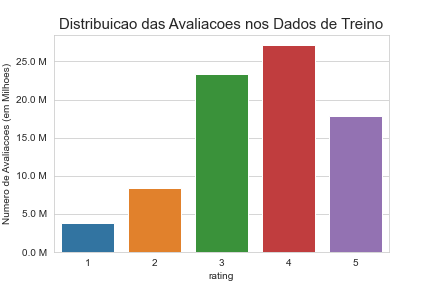

In [9]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribuicao das Avaliacoes nos Dados de Treino', fontsize = 15)
sns.countplot(df_netflix_treino.rating)
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Numero de Avaliacoes (em Milhoes)')
plt.show()

__Does the day of the week influence user evaluation? Let's add a column with the day of the week and find out.__

In [5]:
# Parameter to avoid warning due to high volume of data
pd.options.mode.chained_assignment = None

In [6]:
# Extract the day of the week and write it to a new column
df_netflix_treino['dia_semana'] = df_netflix_treino['date'].dt.strftime('%A')
df_netflix_treino.head()

,movie,user,rating,date,dia_semana
0,10341,510180,4,1999-11-11,Thursday
1,1798,510180,5,1999-11-11,Thursday
2,10774,510180,3,1999-11-11,Thursday
3,8651,510180,2,1999-11-11,Thursday
4,14660,510180,2,1999-11-11,Thursday


<IPython.core.display.Javascript object>


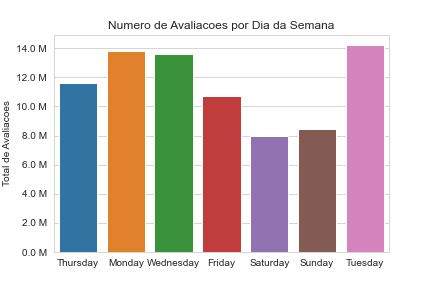

In [31]:
# Plot
fig, ax = plt.subplots()
sns.countplot(x = 'dia_semana', data = df_netflix_treino, ax = ax)
plt.title('Numero de Avaliacoes por Dia da Semana')
plt.ylabel('Total de Avaliacoes')
plt.xlabel('')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

__Let's calculate the average of reviews by day of the week.__

In [7]:
# Average ratings per day of the week
media_dia_semana = df_netflix_treino.groupby(by = ['dia_semana'])['rating'].mean()
print('Media de Avaliacoes:')
print('-'*30)
print(media_dia_semana)
print('\n')

Media de Avaliacoes:
------------------------------
dia_semana
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




The day of the week does not seem to have any influence on the users' evaluation.

__Let's analyze user reviews over time.__

<IPython.core.display.Javascript object>


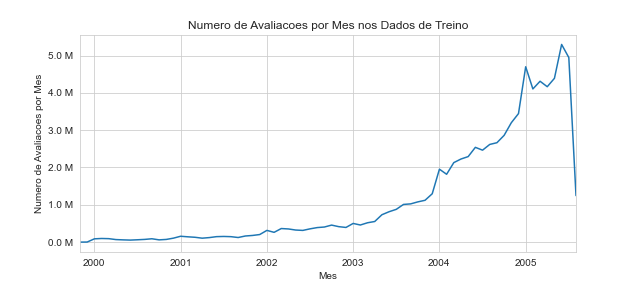

In [13]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax = df_netflix_treino.resample('m', on = 'date')['rating'].count().plot()
ax.set_title('Numero de Avaliacoes por Mes nos Dados de Treino')
plt.xlabel('Mes')
plt.ylabel('Numero de Avaliacoes por Mes')
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
plt.show()

Clearly there is an increase in user ratings over time, either due to the greater number of users or because users have learned to use the feature.

__Let's check out the users who gave the most movie ratings.__

In [8]:
# Number of reviews per user
num_aval_por_user = df_netflix_treino.groupby(by = 'user')['rating'].count().sort_values(ascending = False)
num_aval_por_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

In [15]:
# Statistical summary
num_aval_por_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

__Let's create a plot of the probability density function and the cumulative distribution function.__

The probability density function (pdf) and cumulative distribution function (cdf) are two of the most important statistical functions in reliability and are closely related. When these functions are known, almost any other reliability measure of interest can be derived or obtained. More about it here:

http://reliawiki.org/index.php/Basic_Statistical_Background

<IPython.core.display.Javascript object>


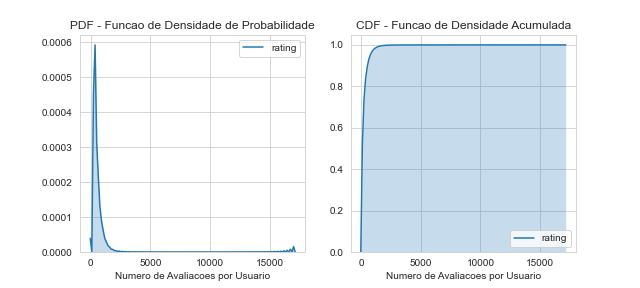

In [16]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax1 = plt.subplot(121)
sns.kdeplot(num_aval_por_user, shade = True, ax = ax1)
plt.xlabel('Numero de Avaliacoes por Usuario')
plt.title('PDF - Funcao de Densidade de Probabilidade')
ax2 = plt.subplot(122)
sns.kdeplot(num_aval_por_user, shade = True, cumulative = True, ax = ax2)
plt.xlabel('Numero de Avaliacoes por Usuario')
plt.title('CDF - Funcao de Densidade Acumulada')
plt.show()

Note that the vast majority of users have less than 1000 reviews.

__How many reviews are in the last 5% of all reviews??__

In [10]:
# Let's extract the percentiles
percentis = num_aval_por_user.quantile(np.arange(0, 1.01, 0.01), interpolation = 'higher')

In [18]:
# Viewing 5 out of 5
percentis[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


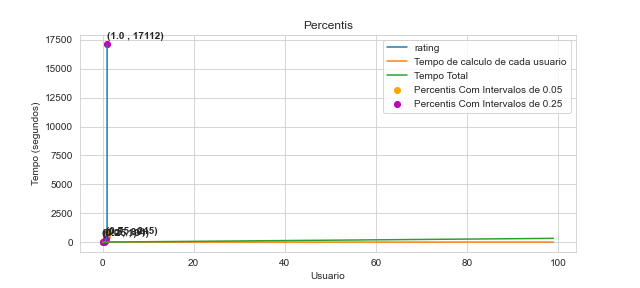

In [11]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.title("Percentis")
percentis.plot()

# Quartiles with a difference of 0.05
plt.scatter(x = percentis.index[::5], 
            y = percentis.values[::5], 
            c = 'orange', 
            label = "Percentis Com Intervalos de 0.05")

# Quartiles with a difference of 0.25
plt.scatter(x = percentis.index[::25], 
            y = percentis.values[::25], 
            c = 'm', 
            label = "Percentis Com Intervalos de 0.25")

# Labels and legend
plt.ylabel('Número de Avaliações Por Usuário')
plt.xlabel('Valor no Percentis')
plt.legend(loc = 'best')

# Let's mark the 25th, 50th, 75th and 100th percentiles
for x,y in zip(percentis.index[::25], percentis[::25]):
    plt.annotate(s = "({} , {})".format(x,y), xy = (x,y), xytext = (x-0.05, y+500), fontweight = 'bold')

plt.show()

- There are some movies (which are very popular) that are rated by a large number of users.
    
- But most movies (like 90%) have a few hundred ratings.

## Sparse Matrix Creation

![title](imagens/Sparse_Matrix.png)

![title](imagens/Matriz_Esparsa.png)

### Creation of the Sparse Training Matrix

In [12]:
# We create the sparse array in Numpy format if it doesn't exist
# If it exists, we just load it from disk
if os.path.isfile('dados/matriz_esparsa_treino.npz'):
    matriz_esparsa_treino = sparse.load_npz('dados/matriz_esparsa_treino.npz')
    print('Matriz Carregada.')
else:
    matriz_esparsa_treino = sparse.csr_matrix((df_netflix_treino.rating.values, (df_netflix_treino.user.values,
                                                                                  df_netflix_treino.movie.values)),)
    print('Matriz Criada. O shape eh: (user, movie): ', matriz_esparsa_treino.shape)
    sparse.save_npz('dados/matriz_esparsa_treino.npz', matriz_esparsa_treino)
    print('Matriz salva em disco.')

Matriz Carregada.


In [13]:
# We calculate the sparsity of the matrix
linhas, colunas = matriz_esparsa_treino.shape
elementos_nao_zero = matriz_esparsa_treino.count_nonzero()
print('Esparsidade da matriz de treino: {} % '.format( (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Esparsidade da matriz de treino: 99.8292709259195 % 


In [22]:
elementos_nao_zero
print('elementos nao zero (treino): %s' %elementos_nao_zero)

elementos nao zero (treino): 80384405


### Creation of the Sparse Test Matrix

In [14]:
# We create the sparse array in Numpy format if it doesn't exist
# If it exists, we just load it from disk
if os.path.isfile('dados/matriz_esparsa_teste.npz'):
    matriz_esparsa_teste = sparse.load_npz('dados/matriz_esparsa_teste.npz')
    print('Matriz Carregada.')
else:
    matriz_esparsa_teste = sparse.csr_matrix((df_netflix_teste.rating.values, (df_netflix_teste.user.values,
                                                                                  df_netflix_teste.movie.values)),)
    print('Matriz Criada. O shape eh: (user, movie): ', matriz_esparsa_teste.shape)
    sparse.save_npz('dados/matriz_esparsa_teste.npz', matriz_esparsa_teste)
    print('Matriz salva em disco.')

Matriz Carregada.


In [15]:
# We calculate the sparsity of the matrix
linhas, colunas = matriz_esparsa_teste.shape
elementos_nao_zero = matriz_esparsa_teste.count_nonzero()
print('Esparsidade da matriz de teste: {} % '.format( (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Esparsidade da matriz de teste: 99.95731772988694 % 


In [25]:
elementos_nao_zero
print('elementos nao zero (teste): %s' %elementos_nao_zero)

elementos nao zero (teste): 20096102


__Let's calculate the global average of all movie ratings, average rating per user and average rating per movie.__

In [16]:
# Below we calculate the global average of all user reviews
medias_treino = dict()
medias_treino_global = matriz_esparsa_treino.sum() / matriz_esparsa_treino.count_nonzero()
medias_treino['global'] = medias_treino_global
medias_treino

{'global': 3.582890686321557}

__Let's make a function for calculating the average of ratings.__

In [17]:
# Average calculation function
def calcula_media_avaliacoes(sparse_matrix, of_users):
    
    # Average user/axes ratings
    # 1 = user axis
    # 0 = movie axis
    ax = 1 if of_users else 0

    # Sum
    sum_of_ratings = sparse_matrix.sum(axis = ax).A1 
    
    # Boolean array of ratings (whether a user has rated a movie or not)
    is_rated = sparse_matrix != 0
    
    # Number of ratings for each user or movie
    no_of_ratings = is_rated.sum(axis = ax).A1
    
    # Max user IDs and movies in sparse array
    u, m = sparse_matrix.shape
    
    # We created a dictionary of users and their average ratings
    media_aval = {i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i] != 0}

    # Returns the dictionary of rating averages
    return media_aval

__Below we calculate the average ratings per user.__

In [18]:
# Average user ratings
medias_treino['user'] = calcula_media_avaliacoes(matriz_esparsa_treino, of_users = True)

In [29]:
# View the dictionary
medias_treino

{'global': 3.582890686321557,
 'user': {6: 3.5160550458715596,
  7: 3.992957746478873,
  10: 3.3781094527363185,
  25: 3.5,
  33: 3.787878787878788,
  42: 3.9322033898305087,
  59: 3.698717948717949,
  79: 3.5559947299077734,
  83: 4.0,
  87: 3.544642857142857,
  94: 2.8125,
  97: 3.182377049180328,
  131: 4.0,
  134: 4.703081232492997,
  142: 3.45,
  149: 4.25,
  158: 3.625,
  168: 4.208333333333333,
  169: 3.738562091503268,
  178: 3.0,
  183: 3.7096774193548385,
  188: 3.4456066945606696,
  189: 3.0,
  192: 3.522222222222222,
  195: 3.689655172413793,
  199: 3.974747474747475,
  201: 3.605714285714286,
  242: 2.8392857142857144,
  247: 4.019230769230769,
  248: 3.6511627906976742,
  261: 2.769230769230769,
  265: 3.680297397769517,
  266: 4.102222222222222,
  267: 3.325,
  268: 4.008,
  283: 3.4794816414686824,
  291: 3.4745762711864407,
  296: 3.789473684210526,
  298: 3.8052805280528053,
  299: 3.5555555555555554,
  301: 4.05524861878453,
  302: 3.212,
  304: 3.8051948051948052,
 

In [30]:
# Print
print('Media de Avaliacao do Usuario 149:', medias_treino['user'][149])

Media de Avaliacao do Usuario 149: 4.25


__Below we calculate the average ratings per movie.__

In [19]:
# Average ratings per movie
medias_treino['movie'] = calcula_media_avaliacoes(matriz_esparsa_treino, of_users=False)

In [32]:
# Print
print('Media de Avaliacao do Filme 32:', medias_treino['movie'][32])

Media de Avaliacao do Filme 32: 3.9922680412371134


__Average PDFs and CDs. User reviews and movies (training data).__

<IPython.core.display.Javascript object>


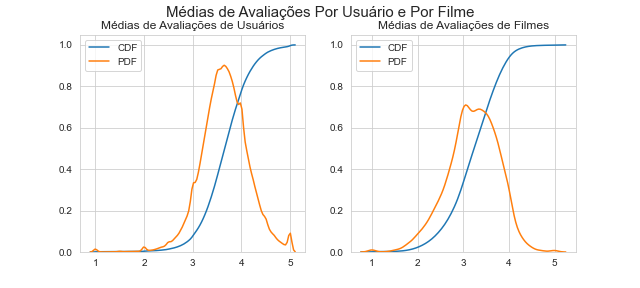

In [33]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.45))
fig.suptitle('Médias de Avaliações Por Usuário e Por Filme', fontsize = 15)

ax1.set_title('Médias de Avaliações de Usuários')

# We get the list of average user ratings from the averages dictionary
medias_usuarios = [rat for rat in medias_treino['user'].values()]
sns.distplot(medias_usuarios, ax = ax1, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_usuarios, ax = ax1, hist = False, label = 'PDF')

ax2.set_title('Médias de Avaliações de Filmes')

# We get the list of average movie ratings from the dictionary
medias_filmes = [rat for rat in medias_treino['movie'].values()]
sns.distplot(medias_filmes, ax = ax2, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_filmes, ax = ax2, hist = False, label = 'PDF')

plt.show()

## Cold Start Problem

In [30]:
# Users Cold start
usuarios_treino = len(medias_treino['user'])
novos_usuarios = total_users - usuarios_treino

In [43]:
# Print
print('Total Geral de Usuarios:', total_users)
print('Total de Usuarios em Treino:', usuarios_treino)
print('Total de Usuarios que nao estao em Treino: {} ({}%)'.format(novos_usuarios,
                                                                   np.round((novos_usuarios / total_users) * 100, 2)))

Total Geral de Usuarios: 480189
Total de Usuarios em Treino: 405041
Total de Usuarios que nao estao em Treino: 75148 (15.65%)


75148 users are not part of the training data, that is, we have no way of learning the evaluation pattern of these users! This is the cold start problem.

In [31]:
# Movies Cold start
filmes_treino = len(medias_treino['movie'])
novos_filmes = total_movies - filmes_treino

In [46]:
# Print
print('Total Geral de Filmes:', total_movies)
print('Total de Filmes em Treino:', filmes_treino)
print('Total de Filmes que nao estao em Treino: {} ({}%)'.format(novos_filmes,
                                                                 np.round((novos_filmes / total_movies) * 100, 2)))

Total Geral de Filmes: 17770
Total de Filmes em Treino: 17424
Total de Filmes que nao estao em Treino: 346 (1.95%)


346 movies do not appear in training data. We will have to deal with this when we work especially on the Machine Learning model.

## Calculating the User Similarity Matrix

In [32]:
# Similarity Calculation Function
def calcula_similaridade_usuario(sparse_matrix,
                                 compute_for_few = False,
                                 top = 100,
                                 verbose = False,
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    
    # Control variables
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind))
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print('Calculando top', top, 'similaridades para cada usuario...')
    start = datetime.now()
    temp = 0
    
    # Loop through matrix
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        # Calculating cosine similarity
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print('Calculo concluido para {} usuarios [tempo total: {}]'.format(temp, datetime.now() - start))
                
    if verbose: print('Criacao de matriz esparsa a partir das semelhancas computadas...')
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Tempo de calculo de cada usuario')
        plt.plot(np.cumsum(time_taken), label = 'Tempo Total')
        plt.legend(loc = 'best')
        plt.xlabel('Usuario')
        plt.ylabel('Tempo (segundos)')
        plt.show()
        
    return sparse.csc_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken

In [33]:
# We calculate the similarity

# Beggining milestone
start = datetime.now()

# Calcular uma similaridade
matriz_esparsa_user, _ = calcula_similaridade_usuario(matriz_esparsa_treino,
                                                      compute_for_few = True,
                                                      top = 100,
                                                      verbose = True)

print('Tempo Total de Processamento:', datetime.now() - start)

Calculando top 100 similaridades para cada usuario...
Calculo concluido para 20 usuarios [tempo total: 0:01:05.152476]
Calculo concluido para 40 usuarios [tempo total: 0:02:12.117495]
Calculo concluido para 60 usuarios [tempo total: 0:03:16.147204]
Calculo concluido para 80 usuarios [tempo total: 0:04:21.031164]
Calculo concluido para 100 usuarios [tempo total: 0:05:26.776694]
Criacao de matriz esparsa a partir das semelhancas computadas...
Tempo Total de Processamento: 0:05:35.913383


We have 405,041 users in our training set and computing similarities between them (17K dimensional vector) is time consuming.


We will try to reduce the dimensions using SVD in order to speed up the process.

## Dimensionality Reduction with TruncatedSVD

In [34]:
# Dimensionality reduction

# Beggining milestone
start = datetime.now()

# Create TruncatedSVD object by reducing dimensionality to 500 dimensions
netflix_svd = TruncatedSVD(n_components = 100, algorithm = 'randomized', random_state = 15)

# Applies TruncatedSVD
trunc_svd = netflix_svd.fit_transform(matriz_esparsa_treino)

print('Tempo Total de Processamento:', datetime.now() - start)

Tempo Total de Processamento: 0:02:56.280521


__Let's calculate the variance explained by the components.__

In [35]:
# Calculates the explained variance
expl_var = np.cumsum(netflix_svd.explained_variance_ratio_)

<IPython.core.display.Javascript object>


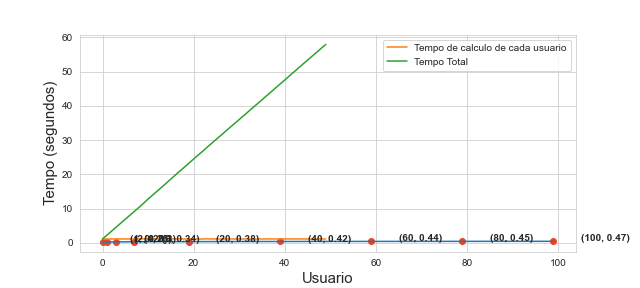

In [36]:
# Plot
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = plt.figaspect(.45))

ax1.set_ylabel('Variancia Explicada', fontsize = 15)
ax1.set_xlabel('Fatores Latentes', fontsize = 15)
ax1.plot(expl_var)

# Let's mark some combinations of (latent factors, explained variance) to make the graph clearer
ind = [1, 2, 4, 8, 20, 40, 60, 80, 100]
ax1.scatter(x = [i-1 for i in ind], y = expl_var[[i-1 for i in ind]], c = '#ee4422')

for i in ind:
    ax1.annotate(s='({}, {})'.format(i, np.round(expl_var[i-1], 2)), xy = (i-1, expl_var[i-1]),
                 xytext = (i+5, expl_var[i-1]-0.01), fontweight = 'bold')
    
plt.show()

With 100 components we explain approximately 47% of the data variance.


In [37]:
# Let's project our matrix in a space of 100 dimensions (modified to 100 dimensions)
start = datetime.now()
trunc_matrix = matriz_esparsa_treino.dot(netflix_svd.components_.T)
print('Tempo de Processamento:', datetime.now() - start)

Tempo de Processamento: 0:00:04.479304


In [38]:
# Shape
trunc_matrix.shape

(2649430, 100)

In [39]:
# Type
type(trunc_matrix)

numpy.ndarray

In [40]:
# Let's create and save to disk the matrix with the dimensionality reduced to 100 dimensions
if not os.path.isfile('dados/matriz_esparsa_user_truncada.npz'):
    matriz_esparsa_user_truncada = sparse.csr_matrix(trunc_matrix)
    sparse.save_npz('dados/matriz_esparsa_user_truncada', matriz_esparsa_user_truncada)
else:
    matriz_esparsa_user_truncada = sparse.load_npz('dados/matriz_esparsa_user_truncada.npz')

In [41]:
# Checking the shape
matriz_esparsa_user_truncada.shape

(2649430, 100)

__Now we recalculate the similarity of users using the truncated matrix.__

In [43]:
# Calculates similarity of users

# Beggining milestone
start = datetime.now()

# Calculates the similarity
trunc_sim_matrix, _ = calcula_similaridade_usuario(matriz_esparsa_user_truncada,
                                                   compute_for_few = True,
                                                   top = 50,
                                                   verbose = True)

print('Tempo de Processamento:', datetime.now() - start)

Calculando top 50 similaridades para cada usuario...
Calculo concluido para 20 usuarios [tempo total: 0:00:23.316674]
Calculo concluido para 40 usuarios [tempo total: 0:00:46.381722]
Criacao de matriz esparsa a partir das semelhancas computadas...
Tempo de Processamento: 0:01:02.438457


## Calculating Film Similarity Matrix

In [44]:
# Calculation of movie similarity

# Beggining milestone
start = datetime.now()

# Create if not exist
if not os.path.isfile('dados/matriz_esparsa_filme.npz'):
    matriz_esparsa_filme = cosine_similarity(X = matriz_esparsa_treino.T, dense_output = False)
    print('Matriz Criada.')
    sparse.save_npz('dados/matriz_esparsa_filme.npz', matriz_esparsa_filme)
    print('Matriz Salva em Disco.')
else:
    matriz_esparsa_filme = sparse.load_npz('dados/matriz_esparsa_filme.npz')
    print('Matriz Carregada')
    
print('Tempo de Processamento:', datetime.now() - start)

Matriz Crriada.
Matriz Salva em Disco.
Tempo de Processamento: 0:06:26.674130


In [45]:
# Shape
matriz_esparsa_filme.shape

(17771, 17771)

In [46]:
# Extract the movie IDs
movie_ids = np.unique(matriz_esparsa_filme.nonzero()[1])

In [47]:
# Calculates movie similarity according to user rating standard

# Beggining milestone
start = datetime.now()

# Dictionary to store the similarities
filmes_similares = dict()

# Loop through movie IDs
for movie in movie_ids:
    
    # We get the top similar movies and store them in the dictionary
    filmes_sim = matriz_esparsa_filme[movie].toarray().ravel().argsort()[::-1][1:]
    filmes_similares[movie] = filmes_sim[:100]
    
print('Tempo de Processamento:', datetime.now() - start)

Tempo de Processamento: 0:00:19.155311


In [48]:
# Movies similar to ID 43 movie
filmes_similares[43]

array([ 6938,  3353, 15088, 14888,  7550,  3257,  8115,  1054, 11436,
        8309, 11181, 15275,  2041,  7211, 12321,  2619,  9667,   568,
       14988,  7044, 10062,  9895, 15061,  5916,  1113, 11557, 16935,
        7498,  6926,   512, 14415, 13525,  2466,  9468,  8974, 15157,
        1808, 12396,  1944,  3645,  4222,  9893,  3362, 10777,  7543,
        9883,  4062,  7185,  7107,  9143, 17086, 13000, 16184,  5723,
        8452,  3068,  2943, 16515, 13429, 13885,  9664, 12229,   101,
       17602, 17564, 14189, 15292, 13802,  1737, 12650, 17444, 12712,
       15639, 14024,   603,  6081, 10534, 17717, 14824,  9804, 15438,
       15191,  9794,  7137,  7408, 10584,  6629,  1639, 14614,  1927,
        2202, 17755,  5122, 16804,   887,  1768, 16101, 14037,  5666,
         991], dtype=int64)

__Now let's find the most similar movies using the similarity matrix.__

In [52]:
# Let's load movie titles from csv file provided by Netflix
titulos_filmes = pd.read_csv('dados/movie_titles.csv',
                            sep = ',',
                            header = None,
                            names = ['ID_Filme', 'Ano_Lancamento', 'Titulo'],
                            verbose = True,
                            index_col = 'ID_Filme',
                            encoding = 'ISO-8859-1')

Tokenization took: 4.72 ms
Type conversion took: 8.15 ms
Parser memory cleanup took: 0.00 ms


In [53]:
# Data viewing
titulos_filmes.head()

,Ano_Lancamento,Titulo
ID_Filme,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


__Let's see what movies are similar to ID 43 movie.__

In [51]:
# Movie ID
id_filme = 43

In [57]:
# Print
print('Filme:', titulos_filmes.loc[id_filme].values[1])
print('Total de Avaliacoes de Usuarios = {}.'.format(matriz_esparsa_treino[:,id_filme].getnnz()))
print('Encontramos {} filmes que sao similares a este e vamos imprimir os mais similares.'.format(matriz_esparsa_filme[:, id_filme].getnnz()))

Filme: Silent Service
Total de Avaliacoes de Usuarios = 102.
Encontramos 17300 filmes que sao similares a este e vamos imprimir os mais similares.


In [58]:
# Finding all the similarities
similarities = matriz_esparsa_filme[id_filme].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:]

<IPython.core.display.Javascript object>


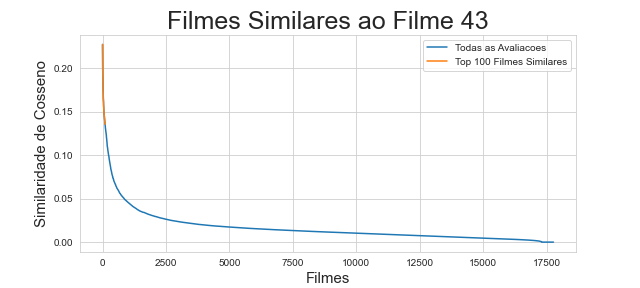

In [59]:
# Plot
fig = plt.figure(figsize = plt.figaspect(0.45))
plt.plot(similarities[sim_indices], label = 'Todas as Avaliacoes')
plt.plot(similarities[sim_indices[:100]], label = 'Top 100 Filmes Similares')
plt.title('Filmes Similares ao Filme {}'.format(id_filme), fontsize = 25)
plt.xlabel('Filmes', fontsize = 15)
plt.ylabel('Similaridade de Cosseno', fontsize = 15)
plt.legend()
plt.show()

In [60]:
# Here the top 10 movies most similar to movie 43
titulos_filmes.loc[sim_indices[:10]]

,Ano_Lancamento,Titulo
ID_Filme,,
6938,1995.0,Battle Skipper
3353,1999.0,Midnight Panther
15088,1996.0,Yamamoto Yohko: Starship Girl
14888,1996.0,Ayane's High Kick
7550,1996.0,Big Wars
3257,1990.0,Takegami: Guardian of Darkness: War God
8115,2000.0,Virgin Fleet
1054,1986.0,Odin: Photon Space Sailer Starlight
11436,1995.0,Super Atragon


We could already complete the project here, as we already have a recommender system. But we will go further and build a Machine Learning model to make the predictions. We will work on this in the next step.